In [1]:
# set path data from folder in google drive
# from google.colab import drive
# drive.mount('/content/gdrive')
path_image ='dog.jpg'

In [2]:
#Import các thư viện cần thiết
import matplotlib
import numpy as np
import numpy.matlib
import random
import PIL
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Khai báo các thông số của mô hình K-means

k_clusters = 7 # Tổng số các clusters mà chúng ta muốn
max_iter = 50 #Tổng số lần chạy của thuật toán K-means trước khi kết thúc

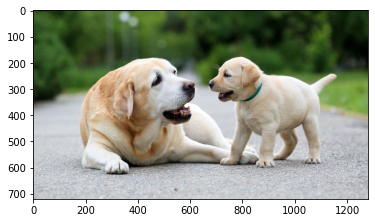

In [4]:
# Đọc hiển thị bức ảnh đầu vào
image = PIL.Image.open(path_image)
matplotlib.pyplot.imshow(image)
image = np.asarray(image)

In [5]:
# Lấy các thông tin của bức ảnh như lấy thông số dòng và thông số cột cũng như chuyển mỗi giá trị pixel về dạng [0,1].
# Chuyển các giá trị pixel về dạng [0,1] giúp thuật toán k-means xử lý hiểu quả hơn.
image_height = image.shape[0]
image_width = image.shape[1]
image = image/255
img_1d = image.reshape(image.shape[0]*image.shape[1],3)
print(img_1d.shape)
print(img_1d)
# Nhận xét, chúng ta có thể thấy ảnh sẽ đưa về 1 danh sách có chiều height x width, mỗi giá trị có 3 thông số tương ứng với 3 giá trị màu RGB


(921600, 3)
[[0.23529412 0.36470588 0.15686275]
 [0.23137255 0.36078431 0.15294118]
 [0.22745098 0.35294118 0.15686275]
 ...
 [0.75686275 0.76862745 0.79607843]
 [0.7372549  0.74901961 0.77647059]
 [0.7254902  0.7372549  0.76470588]]


In [6]:
# Hàm khởi tạo ngẫu nghiên giá trị centroids.
# Tham số đầu vào là ảnh X và số lớp clusters K.
def init_centroids_in_pixel_func(img_1d,k_clusters):
    c = random.sample(list(img_1d),k_clusters)
    return c

# Hàm np.random.rand sẽ tạo giá trị từ khoảng 0 đến 1: https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html
def init_centroids_random_func(img_1d,k_clusters):
    img1d_random = np.random.rand(len(img_1d),3)
    c = random.sample(list(img1d_random),k_clusters)
    return c


In [7]:
print(init_centroids_in_pixel_func(img_1d,k_clusters))

print(init_centroids_random_func(img_1d,k_clusters))

[array([0.78823529, 0.80784314, 0.83137255]), array([0.93333333, 0.83529412, 0.75686275]), array([0.14509804, 0.23137255, 0.09019608]), array([0.79607843, 0.76078431, 0.69411765]), array([0.50980392, 0.67058824, 0.37254902]), array([0.1372549 , 0.2627451 , 0.10196078]), array([0.70196078, 0.70588235, 0.72156863])]
[array([0.83703625, 0.22401476, 0.88018058]), array([0.06250724, 0.4120224 , 0.24767892]), array([0.48092648, 0.65032236, 0.76245303]), array([0.74219512, 0.40238797, 0.79952008]), array([0.85385096, 0.55944457, 0.20944108]), array([0.06657444, 0.15811277, 0.484482  ]), array([0.8969543 , 0.98660189, 0.49904369])]


In [8]:
# Tìm các điểm giá trị pixel gần với mỗi giá trị centroids. 
# Ta coi công thức Hàm mất mát và bài toán tối ưu ở link sau sẽ hiểu cái công thức toán học ở đây
# https://machinelearningcoban.com/2017/01/01/kmeans/
def closest_centroids(X,c):
    K = np.size(c,0)
    idx = np.zeros((np.size(X,0),1))
    array = np.empty((np.size(X,0),1))
    for i in range(0,K):
        y = c[i]
        temp = np.ones((np.size(X,0),1))*y
        b = np.power(np.subtract(X,temp),2)
        a = np.sum(b,axis = 1)
        a = np.asarray(a)
        a.resize((np.size(X,0),1))
        array = np.append(array, a, axis=1)
    array = np.delete(array,0,axis=1)
    idx = np.argmin(array, axis=1)
    return idx

In [9]:
# Hàm tính toán các giá trị các centroids. 
def compute_centroids(img_1d,idx,k_clusters):
    n = np.size(img_1d,1)
    centroids = np.zeros((k_clusters,n))
    for i in range(0,k_clusters):
        ci = idx ==i
        ci = ci.astype(int)
        total_number = sum(ci);
        ci.resize((np.size(img_1d,0),1))
        total_matrix = np.matlib.repmat(ci,1,n)
        ci = np.transpose(ci)
        total = np.multiply(img_1d,total_matrix)
        centroids[i] = (1/total_number)*np.sum(total,axis=0)
    return centroids

In [10]:
# Hàm chạy thuật toán K-mean, đầu vào là ảnh X sau khi tiền xử lý, các giá trị center được khởi tạo và thông số số vòng lặp chạy thuật toán k-means

In [11]:
# Hàm chạy thuật toán K-mean, đầu vào là ảnh X sau khi tiền xử lý, các giá trị center được khởi tạo và thông số số vòng lặp chạy thuật toán k-means
def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    if init_centroids == "random":
      #Để đảm bảo bài toán luôn chạy thành công, vì hàm random khá hên xui, nếu càng gần với các giá trị bức ảnh thì nó chạy tốt, không thì ngược lại
      #Nên ta thay thế bằng hàm init_centroids_in_pixel_func(img_1d,k_clusters) ở mọi statement
        # initial_centroids = init_centroids_random_func(img_1d,k_clusters)
        initial_centroids = init_centroids_in_pixel_func(img_1d,k_clusters)
    else:  
        initial_centroids = init_centroids_in_pixel_func(img_1d,k_clusters)
    m = np.size(img_1d,0)
    n = np.size(img_1d,1)
    K = np.size(initial_centroids,0)
    centroids = initial_centroids
    previous_centroids = centroids
    labels  = np.zeros((m,1))
    for i in range(1,max_iter):
        labels  = closest_centroids(img_1d,centroids)
        centroids = compute_centroids(img_1d,labels ,k_clusters)
    return centroids, labels

In [12]:
# Bắt đầu chạy thuật toán K-means trên bức ảnh đầu vào
# 1. Chạy các thuật toán K-means
centroids,labels = kmeans(img_1d,k_clusters,max_iter)
# Hiện thị kích thước ví dụ số lượng center : vì mình chọn K =16 nên là sẽ 1 vector 16 chiều, và 1 giá trị là 1 mảng chứa giá trị 3 gam màu RGB
print(np.shape(centroids))
print(np.shape(labels))
print("Hiển thị label: ", labels)
print("Hiển thị giá trị centroids :", centroids)

(7, 3)
(921600,)
Hiển thị label:  [1 1 1 ... 6 6 6]
Hiển thị giá trị centroids : [[0.35001157 0.40308943 0.21805871]
 [0.19528848 0.29731232 0.12795124]
 [0.54476038 0.52981439 0.39542712]
 [0.70180938 0.66483259 0.61312784]
 [0.91468209 0.91089257 0.90556957]
 [0.08564259 0.14495892 0.05792434]
 [0.78677096 0.78918657 0.79429246]]


In [13]:
# Đoạn code này sẽ tìm các điểm gần với điểm center và đặt giá trị của center là các giá trị gần trong 1 nhóm đó.
image_compressed = centroids[labels]
print(image_compressed)
image_compressed = np.reshape(image_compressed, (image_height, image_width, 3))
print("Kích thước ảnh sau khi reshape: ", np.shape(image_compressed))

[[0.19528848 0.29731232 0.12795124]
 [0.19528848 0.29731232 0.12795124]
 [0.19528848 0.29731232 0.12795124]
 ...
 [0.78677096 0.78918657 0.79429246]
 [0.78677096 0.78918657 0.79429246]
 [0.78677096 0.78918657 0.79429246]]
Kích thước ảnh sau khi reshape:  (720, 1280, 3)


In [14]:
# Lưu ảnh xuống thành file image sau khi nén
from PIL import Image  
image_compressed = Image.fromarray((image_compressed * 255).astype(numpy.uint8))
image_compressed.save('meo_compression.jpg')

Ảnh sau khi nén pixel


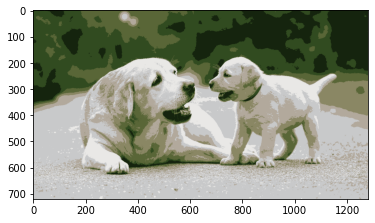

In [15]:
# Show ví dụ thử
import matplotlib
print("Ảnh sau khi nén pixel")
matplotlib.pyplot.imshow(image_compressed)

In [16]:
# Hiển thị kết quả kích thước ảnh đầu vào và ảnh sau khi nén
info = os.stat(path_image)
print("Kích thước ảnh gốc ban đầu: ",info.st_size/1024,"KB")
info = os.stat('meo_compression.jpg')
print("Kích thước ảnh sau khi sử dụng K-mean: ",info.st_size/1024,"KB")
print("Hiển thị labels: ", labels)
print("Hiển thị giá trị centroids :", centroids)

Kích thước ảnh gốc ban đầu:  141.8994140625 KB
Kích thước ảnh sau khi sử dụng K-mean:  110.9375 KB
Hiển thị labels:  [1 1 1 ... 6 6 6]
Hiển thị giá trị centroids : [[0.35001157 0.40308943 0.21805871]
 [0.19528848 0.29731232 0.12795124]
 [0.54476038 0.52981439 0.39542712]
 [0.70180938 0.66483259 0.61312784]
 [0.91468209 0.91089257 0.90556957]
 [0.08564259 0.14495892 0.05792434]
 [0.78677096 0.78918657 0.79429246]]


KẾT QUẢ CHẠY THUẬT TOÁN KMEANS CỦA THƯ VIỆN SCIKIT-LEARN


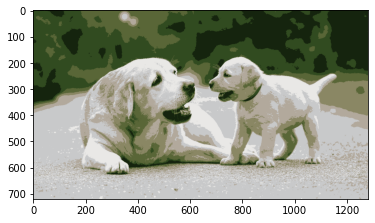

In [17]:
# Thử nghiệm Kmeans của thư viện scikit lean
from sklearn.cluster import KMeans

# chạy thuật toán KMeans sử  dụng thư viện scikit-learn
compressor_kmeans = KMeans(n_clusters=k_clusters, n_init=10, max_iter=max_iter, verbose=0)
compressor_kmeans.fit(img_1d)
pixel_centroid = np.array([list(compressor_kmeans.cluster_centers_[label]) for label in compressor_kmeans.labels_])


# Đưa mảng 1 chiều về dạng ảnh.
pixel_centroids_reshaped = np.reshape(pixel_centroid, (image_height, image_width, 3), "C")


# Lưu ảnh xuống với tên meo_compression_library.jpg
compressed_im_lib = Image.fromarray((pixel_centroids_reshaped * 255).astype(numpy.uint8))
compressed_im_lib.save('meo_compression_library.jpg')


# Hiển thị kết quả sử dụng kmeans của thư viện scikit-learn
print("KẾT QUẢ CHẠY THUẬT TOÁN KMEANS CỦA THƯ VIỆN SCIKIT-LEARN")

matplotlib.pyplot.imshow(image_compressed)
